# Amazon Sales Anomaly Detection

This notebook demonstrates comprehensive anomaly detection on Amazon product sales data using multiple approaches:
- Rule-based anomaly detection
- Isolation Forest (unsupervised ML)
- One-Class SVM (unsupervised ML)

The goal is to identify suspicious products based on pricing, discounts, ratings, and review patterns.

## Step 1: Import Libraries and Setup

Import required libraries for data manipulation, visualization, and machine learning. Set display options for better output formatting.

In [5]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import IsolationForest
from scipy.stats import zscore


pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")


## Step 2: Load and Preview Data

Load the Amazon sales dataset and display the first few rows to understand the data structure and columns available.

In [6]:

df = pd.read_csv("amazon_sales_dataset.csv")  
df.head()


,product_id,product_name,category,discounted_price,actual_price,discount_percentage,rating,rating_count,about_product,user_id,user_name,review_id,review_title,review_content,img_link,product_link
0,B07JW9H4J1,Wayona Nylon Braided USB to Lightning Fast Cha...,Computers&Accessories|Accessories&Peripherals|...,₹399,"₹1,099",64%,4.2,"24,269",High Compatibility : Compatible With iPhone 12...,"AG3D6O4STAQKAY2UVGEUV46KN35Q,AHMY5CWJMMK5BJRBB...","Manav,Adarsh gupta,Sundeep,S.Sayeed Ahmed,jasp...","R3HXWT0LRP0NMF,R2AJM3LFTLZHFO,R6AQJGUP6P86,R1K...","Satisfied,Charging is really fast,Value for mo...",Looks durable Charging is fine tooNo complains...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Wayona-Braided-WN3LG1-Sy...
1,B098NS6PVG,Ambrane Unbreakable 60W / 3A Fast Charging 1.5...,Computers&Accessories|Accessories&Peripherals|...,₹199,₹349,43%,4.0,"43,994","Compatible with all Type C enabled devices, be...","AECPFYFQVRUWC3KGNLJIOREFP5LQ,AGYYVPDD7YG7FYNBX...","ArdKn,Nirbhay kumar,Sagar Viswanathan,Asp,Plac...","RGIQEG07R9HS2,R1SMWZQ86XIN8U,R2J3Y1WL29GWDE,RY...","A Good Braided Cable for Your Type C Device,Go...",I ordered this cable to connect my phone to An...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Ambrane-Unbreakable-Char...
2,B096MSW6CT,Sounce Fast Phone Charging Cable & Data Sync U...,Computers&Accessories|Accessories&Peripherals|...,₹199,"₹1,899",90%,3.9,"7,928",【 Fast Charger& Data Sync】-With built-in safet...,"AGU3BBQ2V2DDAMOAKGFAWDDQ6QHA,AESFLDV2PT363T2AQ...","Kunal,Himanshu,viswanath,sai niharka,saqib mal...","R3J3EQQ9TZI5ZJ,R3E7WBGK7ID0KV,RWU79XKQ6I1QF,R2...","Good speed for earlier versions,Good Product,W...","Not quite durable and sturdy,https://m.media-a...",https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Sounce-iPhone-Charging-C...
3,B08HDJ86NZ,boAt Deuce USB 300 2 in 1 Type-C & Micro USB S...,Computers&Accessories|Accessories&Peripherals|...,₹329,₹699,53%,4.2,"94,363",The boAt Deuce USB 300 2 in 1 cable is compati...,"AEWAZDZZJLQUYVOVGBEUKSLXHQ5A,AG5HTSFRRE6NL3M5S...","Omkar dhale,JD,HEMALATHA,Ajwadh a.,amar singh ...","R3EEUZKKK9J36I,R3HJVYCLYOY554,REDECAZ7AMPQC,R1...","Good product,Good one,Nice,Really nice product...","Good product,long wire,Charges good,Nice,I bou...",https://m.media-amazon.com/images/I/41V5FtEWPk...,https://www.amazon.in/Deuce-300-Resistant-Tang...
4,B08CF3B7N1,Portronics Konnect L 1.2M Fast Charging 3A 8 P...,Computers&Accessories|Accessories&Peripherals|...,₹154,₹399,61%,4.2,"16,905",[CHARGE & SYNC FUNCTION]- This cable comes wit...,"AE3Q6KSUK5P75D5HFYHCRAOLODSA,AFUGIFH5ZAFXRDSZH...","rahuls6099,Swasat Borah,Ajay Wadke,Pranali,RVK...","R1BP4L2HH9TFUP,R16PVJEXKV6QZS,R2UPDB81N66T4P,R...","As good as original,Decent,Good one for second...","Bought this instead of original apple, does th...",https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Portronics-Konnect-POR-1...


## Step 3: Data Overview

Get comprehensive information about the dataset including data types, non-null counts, and memory usage to understand data quality and structure.

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1465 entries, 0 to 1464
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   product_id           1465 non-null   object
 1   product_name         1465 non-null   object
 2   category             1465 non-null   object
 3   discounted_price     1465 non-null   object
 4   actual_price         1465 non-null   object
 5   discount_percentage  1465 non-null   object
 6   rating               1465 non-null   object
 7   rating_count         1463 non-null   object
 8   about_product        1465 non-null   object
 9   user_id              1465 non-null   object
 10  user_name            1465 non-null   object
 11  review_id            1465 non-null   object
 12  review_title         1465 non-null   object
 13  review_content       1465 non-null   object
 14  img_link             1465 non-null   object
 15  product_link         1465 non-null   object
dtypes: obj

## Step 4: Data Cleaning Plan

Define the cleaning strategy for numerical columns:
- **discounted_price, actual_price**: Remove ₹ symbol and commas
- **discount_percentage**: Remove % symbol
- **rating**: Extract numeric value from "X out of 5" format
- **rating_count**: Remove commas and convert to integer

## Step 5: Data Cleaning Implementation

Apply the cleaning functions to convert string columns to appropriate numerical data types for analysis. This step is crucial for accurate anomaly detection.

In [8]:
df['discounted_price'] = df['discounted_price'].astype(str).str.replace('₹', '', regex=False).str.replace(',', '', regex=False).astype(float)
df['actual_price'] = df['actual_price'].astype(str).str.replace('₹', '', regex=False).str.replace(',', '', regex=False).astype(float)
df['discount_percentage'] = df['discount_percentage'].astype(str).str.replace('%', '', regex=False).astype(float)
df['rating'] = df['rating'].astype(str).str.extract(r'(\d+\.?\d*)')[0].astype(float)
df['rating_count'] = pd.to_numeric(df['rating_count'].astype(str).str.replace(',', '', regex=False), errors='coerce')


## Step 6: Verify Data Cleaning

Check that the cleaned numerical columns have the correct data types and handle any missing values appropriately.

In [9]:
df[['discounted_price', 'actual_price', 'discount_percentage', 'rating', 'rating_count']].info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1465 entries, 0 to 1464
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   discounted_price     1465 non-null   float64
 1   actual_price         1465 non-null   float64
 2   discount_percentage  1465 non-null   float64
 3   rating               1464 non-null   float64
 4   rating_count         1463 non-null   float64
dtypes: float64(5)
memory usage: 57.4 KB


## Step 7: Feature Engineering and Rule-Based Anomaly Detection

Create new features and implement business logic-based anomaly detection:
- **price_diff**: Difference between actual and discounted price
- **anomaly_invalid_price**: When actual price < discounted price (impossible scenario)
- **anomaly_high_discount**: When discount > 90% (suspiciously high)
- **anomaly_low_rating_high_votes**: When rating < 2 but votes > 1000 (suspicious reviews)
- **anomaly_negative_discount**: When discount < 0 (price increase labeled as discount)

In [10]:
df['price_diff'] = df['actual_price'] - df['discounted_price']
df['anomaly_invalid_price'] = df['actual_price'] < df['discounted_price']
df['anomaly_high_discount'] = df['discount_percentage'] > 90
df['anomaly_low_rating_high_votes'] = (df['rating'] < 2) & (df['rating_count'] > 1000)
df['anomaly_negative_discount'] = df['discount_percentage'] < 0
df['is_anomaly'] = df[['anomaly_invalid_price', 'anomaly_high_discount', 'anomaly_low_rating_high_votes', 'anomaly_negative_discount']].any(axis=1)

## Step 8: Rule-Based Anomaly Summary

Display the results of rule-based anomaly detection, showing the total count and sample of flagged products.

In [13]:
print("Total Anomalies Detected:", df['is_anomaly'].sum())
df[df['is_anomaly']].head()
df['is_anomaly'].value_counts()


Total Anomalies Detected: 6


is_anomaly
False    1459
True        6
Name: count, dtype: int64

## Step 9: Visualize Rule-Based Anomalies

Create scatter plots to visualize the relationship between discount percentage and price difference, highlighting rule-based anomalies.

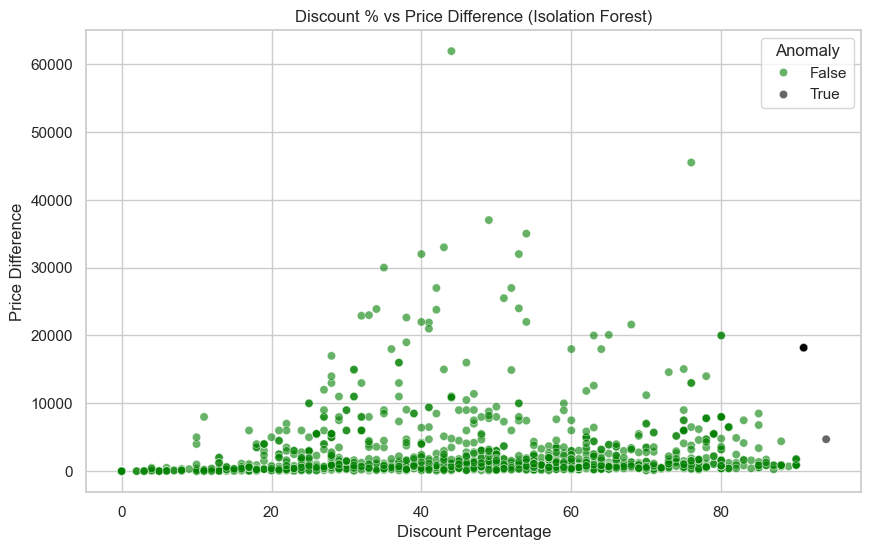

In [14]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df,
    x='discount_percentage',
    y='price_diff',
    hue='is_anomaly',
    palette={True: 'black', False: 'green'},
    alpha=0.6
)
plt.title('Discount % vs Price Difference (Isolation Forest)')
plt.xlabel('Discount Percentage')
plt.ylabel('Price Difference')
plt.legend(title='Anomaly')
plt.show()


Plot 2: Rating vs. Rating Count (suspicious reviews)

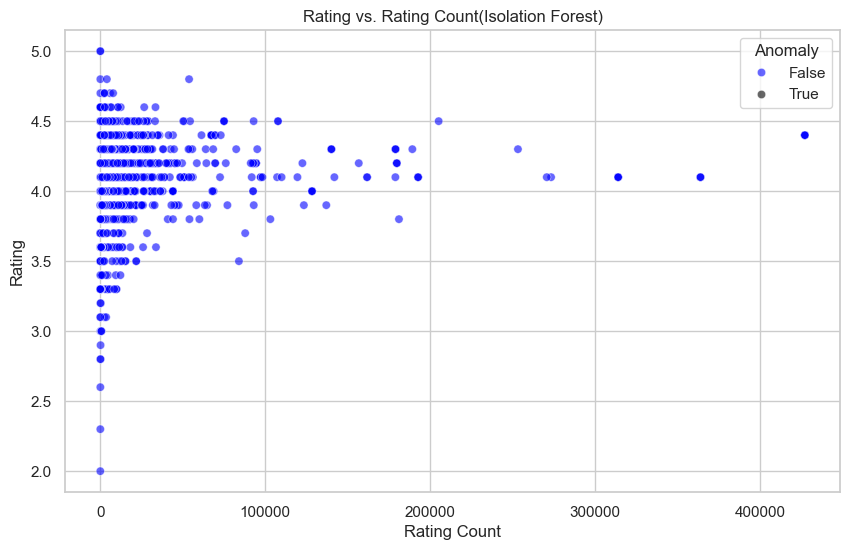

In [15]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df,
    x='rating_count',
    y='rating',
    hue='is_anomaly',
    palette={True: 'black', False: 'blue'},
    alpha=0.6
)
plt.title('Rating vs. Rating Count(Isolation Forest)')
plt.xlabel('Rating Count')
plt.ylabel('Rating')
plt.legend(title='Anomaly')
plt.show()


## Step 10: Isolation Forest Anomaly Detection

Apply the Isolation Forest algorithm, an unsupervised machine learning method, to detect anomalies based on multiple numerical features.

In [16]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler


features = ['actual_price', 'discounted_price', 'discount_percentage', 'rating', 'rating_count']
X = df[features].copy()


X = X.fillna(0)


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


iso_forest = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)
df['iforest_anomaly'] = iso_forest.fit_predict(X_scaled)


df['iforest_anomaly'] = df['iforest_anomaly'].apply(lambda x: True if x == -1 else False)



## Step 11: Isolation Forest Anomaly Summary

Display the number of anomalies detected by Isolation Forest and preview some of the flagged products.

In [17]:
print("Isolation Forest Anomalies:", df['iforest_anomaly'].sum())
df[df['iforest_anomaly']].head()


Isolation Forest Anomalies: 15


,product_id,product_name,category,discounted_price,actual_price,discount_percentage,rating,rating_count,about_product,user_id,user_name,review_id,review_title,review_content,img_link,product_link,price_diff,anomaly_invalid_price,anomaly_high_discount,anomaly_low_rating_high_votes,anomaly_negative_discount,is_anomaly,iforest_anomaly
108,B0B9XLX8VR,VU 139 cm (55 inches) The GloLED Series 4K Sma...,"Electronics|HomeTheater,TV&Video|Televisions|S...",37999.0,65000.0,42.0,4.3,3587.0,Resolution: 4K Ultra HD (3840x2160) | Refresh ...,"AHY6AK5LXBTGXDDXSU57ISMDW55Q,AGULFHMPCHCL32WCI...","UtdBuzz,Mukund Nagvenkar,S.R K.,Pruthvi Raj Goud","R2G4T57OLXDVPL,R3IQ8PWVTWENBY,RH6UHEBP622FT,R3...",Good TV for the price. (But my experience was ...,",Screen quality is good.It's been a month I bo...",https://m.media-amazon.com/images/I/41pdZIhY+g...,https://www.amazon.in/VU-inches-GloLED-Google-...,27001.0,False,False,False,False,False,True
150,B0BB3CBFBM,VU 138 cm (55 inches) Premium Series 4K Ultra ...,"Electronics|HomeTheater,TV&Video|Televisions|S...",29990.0,65000.0,54.0,4.1,211.0,Resolution: 4K (3840x2160) | Refresh Rate: 60 ...,"AEH3MURR76DG3TEX3NXIJVJTKBLA,AGGEFVVI6ZRLVEJHV...","CH Venkatesh,nihar mendon,IP Trading solutions...","RG3VFGY4HM38X,R957RND66RVWX,R1YR2TZI534FFY,R3V...","Valume for money,Can’t turn off HDR in webOS w...","Vu UHD SMART 43"" web os version good tv 20...",https://m.media-amazon.com/images/I/41HhmJpfjN...,https://www.amazon.in/VU-inches-Premium-Ultra-...,35010.0,False,False,False,False,False,True
192,B0B15GSPQW,Samsung 138 cm (55 inches) Crystal 4K Neo Seri...,"Electronics|HomeTheater,TV&Video|Televisions|S...",47990.0,70900.0,32.0,4.3,7109.0,Resolution : Crystal 4K Ultra HD (3840 x 2160)...,"AHDIDVECFGA6OQRNUBPUO6366UGQ,AFSII6HTAHTHGXERU...","Binu,Sabjan,Ramkapil,User,Amazon Customer,gane...","R3RUBB6REUGTT,R281851EB9L5G6,R4ATJJVUY9JO6,R18...","Best(Branded) Budget TV,A high-quality 4k Smar...","Before finalizing the AUE60 55"", I visited Cro...",https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Samsung-inches-Crystal-U...,22910.0,False,False,False,False,False,True
216,B095JQVC7N,OnePlus 138.7 cm (55 inches) U Series 4K LED S...,"Electronics|HomeTheater,TV&Video|Televisions|S...",42999.0,59999.0,28.0,4.1,6753.0,Resolution: 4K Ultra HD (3840x2160) | Refresh ...,"AG3QTVXT2ODRVKOQJJRDV5KA2F2A,AGEYM57JOHPNX77ZY...","Rashmi,Raghvendra,Hari Prasad P,Vishnu singh,T...","R2PF9QV9JEQO9K,R2NEN86P63G4ES,R302B7X6H0GIC0,R...","Almost Perfect!,Review After using 1month,Nice...",Update after 9 months of use:1. The TV is stil...,https://m.media-amazon.com/images/I/41BaZZ48wj...,https://www.amazon.in/OnePlus-138-7-inches-And...,17000.0,False,False,False,False,False,True
249,B09WN3SRC7,Sony Bravia 164 cm (65 inches) 4K Ultra HD Sma...,"Electronics|HomeTheater,TV&Video|Televisions|S...",77990.0,139900.0,44.0,4.7,5935.0,Resolution: 4K Ultra HD (3840 x 2160) | Refres...,"AF6Z2OYIXRPZJHVYN2MFKKYHPHFQ,AH5SAORYVUN5MGIBL...","David P.,Dr. ATUL THAKUR,Shriniwas Patil,Tahir...","R16HCZ0W1TRSMM,R12J7UKQ0FX3O9,R8729SR7LQFUU,R1...",Product installation was excellent but delive...,The delivery people were not careful with the ...,https://m.media-amazon.com/images/I/51uVckL1jR...,https://www.amazon.in/Sony-Bravia-inches-Googl...,61910.0,False,False,False,False,False,True


## Step 12: Visualize Isolation Forest Anomalies

Visualize the anomalies detected by Isolation Forest in the context of discount percentage and price difference.

In [18]:
df[df['iforest_anomaly']][[
    'product_name',
    'actual_price',
    'discounted_price',
    'discount_percentage',
    'rating',
    'rating_count'
]].head(10)


,product_name,actual_price,discounted_price,discount_percentage,rating,rating_count
108,VU 139 cm (55 inches) The GloLED Series 4K Sma...,65000.0,37999.0,42.0,4.3,3587.0
150,VU 138 cm (55 inches) Premium Series 4K Ultra ...,65000.0,29990.0,54.0,4.1,211.0
192,Samsung 138 cm (55 inches) Crystal 4K Neo Seri...,70900.0,47990.0,32.0,4.3,7109.0
216,OnePlus 138.7 cm (55 inches) U Series 4K LED S...,59999.0,42999.0,28.0,4.1,6753.0
249,Sony Bravia 164 cm (65 inches) 4K Ultra HD Sma...,139900.0,77990.0,44.0,4.7,5935.0
255,VU 164 cm (65 inches) The GloLED Series 4K Sma...,85000.0,54990.0,35.0,4.3,3587.0
276,Samsung 138 cm (55 inches) Crystal 4K Series U...,69900.0,45999.0,34.0,4.3,7109.0
283,LG 139 cm (55 inches) 4K Ultra HD Smart LED TV...,79990.0,47990.0,40.0,4.3,1376.0
325,OnePlus 163.8 cm (65 inches) U Series 4K LED S...,69999.0,61999.0,11.0,4.1,6753.0
332,MI 138.8 cm (55 inches) 5X Series 4K Ultra HD ...,69999.0,46999.0,33.0,4.3,21252.0


VISUALIZING ANOMALIES

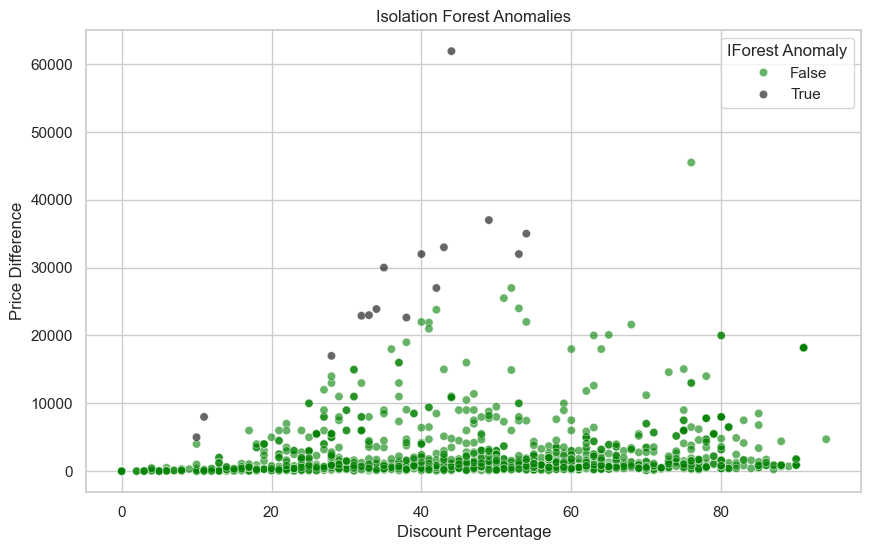

In [23]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=df['discount_percentage'],
    y=df['price_diff'],
    hue=df['iforest_anomaly'],
    palette={True: 'black', False: 'green'},
    alpha=0.6
)
plt.title('Isolation Forest Anomalies')
plt.xlabel('Discount Percentage')
plt.ylabel('Price Difference')
plt.legend(title='IForest Anomaly')
plt.show()


## Step 13: One-Class SVM Anomaly Detection

Apply the One-Class SVM algorithm, another unsupervised machine learning method, to detect anomalies in the dataset.

In [19]:
from sklearn.svm import OneClassSVM


features = ['actual_price', 'discounted_price', 'discount_percentage', 'rating', 'rating_count']
X = df[features].fillna(0)
X_scaled = StandardScaler().fit_transform(X)


svm_model = OneClassSVM(kernel='rbf', nu=0.01, gamma='auto')
df['svm_anomaly'] = svm_model.fit_predict(X_scaled)
df['svm_anomaly'] = df['svm_anomaly'] == -1


## Step 14: Visualize One-Class SVM Anomalies

Visualize the anomalies detected by One-Class SVM 

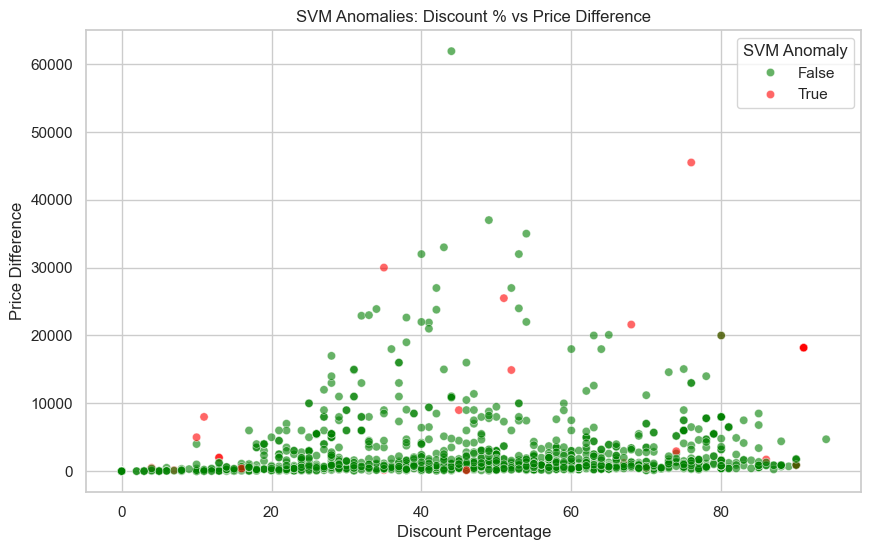

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df,
    x='discount_percentage',
    y='price_diff',
    hue='svm_anomaly',
    palette={True: 'red', False: 'green'},
    alpha=0.6
)
plt.title('SVM Anomalies: Discount % vs Price Difference')
plt.xlabel('Discount Percentage')
plt.ylabel('Price Difference')
plt.legend(title='SVM Anomaly')
plt.show()


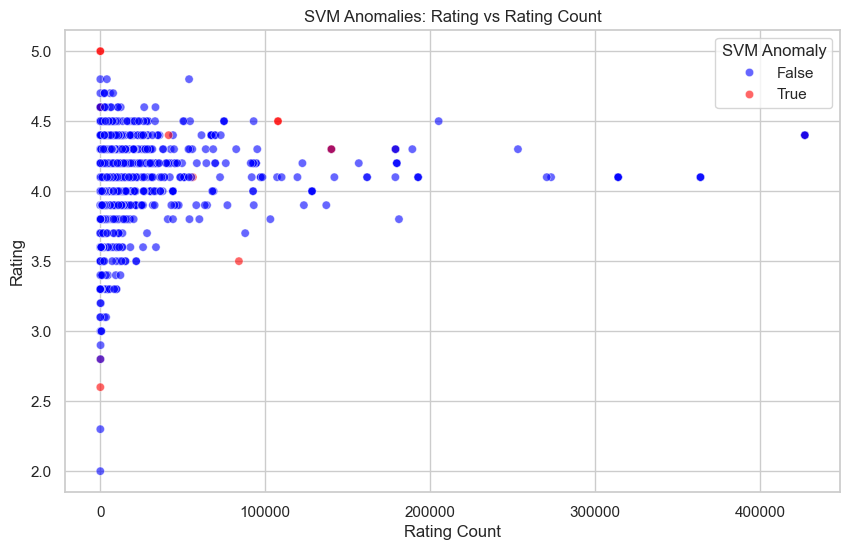

In [32]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df,
    x='rating_count',
    y='rating',
    hue='svm_anomaly',
    palette={True: 'red', False: 'blue'},
    alpha=0.6
)
plt.title('SVM Anomalies: Rating vs Rating Count')
plt.xlabel('Rating Count')
plt.ylabel('Rating')
plt.legend(title='SVM Anomaly')
plt.show()


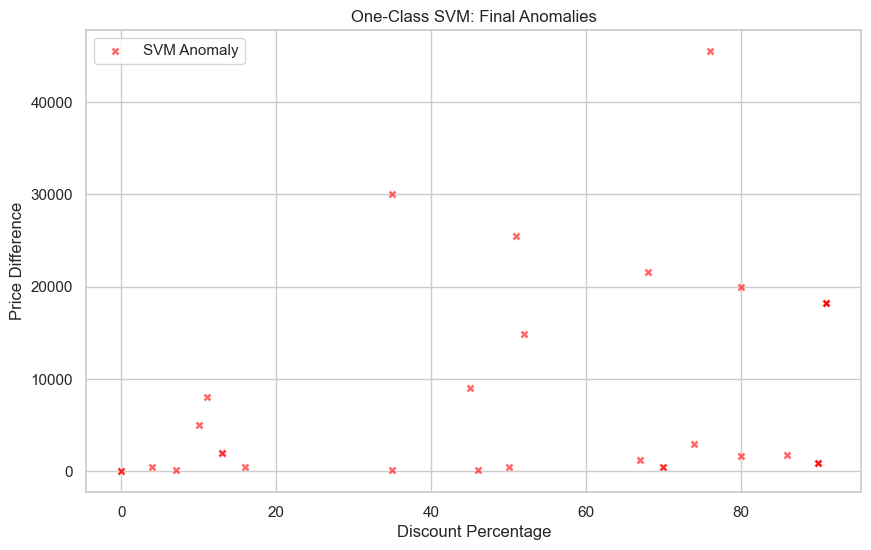

In [21]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df[df['svm_anomaly']],
    x='discount_percentage',
    y='price_diff',
    color='red',
    marker='X',
    alpha=0.6,
    label='SVM Anomaly'
)
plt.title('One-Class SVM: Final Anomalies')
plt.xlabel('Discount Percentage')
plt.ylabel('Price Difference')
plt.legend()
plt.grid(True)
plt.show()


## Step 15: Compare All Anomaly Detection Methods

Visualize and compare the anomalies detected by rule-based, Isolation Forest, and One-Class SVM methods in a single plot.

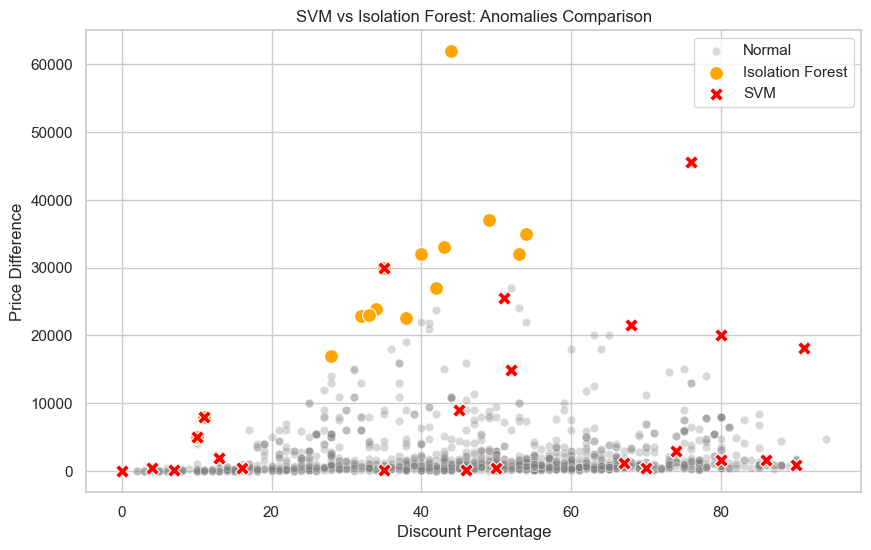

In [22]:
plt.figure(figsize=(10, 6))

sns.scatterplot(
    data=df[(~df['svm_anomaly']) & (~df['iforest_anomaly'])],
    x='discount_percentage',
    y='price_diff',
    color='gray',
    label='Normal',
    alpha=0.3
)

sns.scatterplot(
    data=df[df['iforest_anomaly']],
    x='discount_percentage',
    y='price_diff',
    color='orange',
    marker='o',
    s=100,
    label='Isolation Forest'
)

sns.scatterplot(
    data=df[df['svm_anomaly']],
    x='discount_percentage',
    y='price_diff',
    color='red',
    marker='X',
    s=100,
    label='SVM'
)

plt.title('SVM vs Isolation Forest: Anomalies Comparison')
plt.xlabel('Discount Percentage')
plt.ylabel('Price Difference')
plt.legend()
plt.grid(True)
plt.show()


## Step 17: Hyperparameter Tuning

Optimize the performance of our machine learning models through grid search:
1. Isolation Forest - tune contamination and n_estimators
2. One-Class SVM - tune nu and gamma parameters

In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings('ignore')


def custom_scorer(y_true, y_pred):
    
    y_pred_binary = y_pred == -1
    y_true_binary = y_true == True
    return f1_score(y_true_binary, y_pred_binary)


y_reference = df['is_anomaly']


iforest_param_grid = {
    'n_estimators': [50, 100, 200],
    'contamination': [0.01, 0.05, 0.1],
    'max_features': [0.5, 0.7, 1.0],
    'random_state': [42]
}

svm_param_grid = {
    'kernel': ['rbf'],
    'nu': [0.01, 0.05, 0.1],
    'gamma': ['scale', 'auto', 0.1, 0.01],
}


iforest = IsolationForest()
svm = OneClassSVM()


print("Tuning Isolation Forest...")
iforest_grid = GridSearchCV(
    estimator=iforest,
    param_grid=iforest_param_grid,
    scoring=make_scorer(custom_scorer, greater_is_better=True),
    cv=5,
    n_jobs=-1,
    verbose=1
)

iforest_grid.fit(X_scaled, y_reference)


print("\nBest Isolation Forest Parameters:")
print(iforest_grid.best_params_)
print("Best Score:", iforest_grid.best_score_)


print("\nTuning One-Class SVM...")
svm_grid = GridSearchCV(
    estimator=svm,
    param_grid=svm_param_grid,
    scoring=make_scorer(custom_scorer, greater_is_better=True),
    cv=5,
    n_jobs=-1,
    verbose=1
)

svm_grid.fit(X_scaled, y_reference)

print("\nBest One-Class SVM Parameters:")
print(svm_grid.best_params_)
print("Best Score:", svm_grid.best_score_)

Tuning Isolation Forest...
Fitting 5 folds for each of 27 candidates, totalling 135 fits

Best Isolation Forest Parameters:
{'contamination': 0.1, 'max_features': 0.5, 'n_estimators': 50, 'random_state': 42}
Best Score: 0.04242424242424242

Tuning One-Class SVM...
Fitting 5 folds for each of 12 candidates, totalling 60 fits

Best One-Class SVM Parameters:
{'gamma': 0.1, 'kernel': 'rbf', 'nu': 0.05}
Best Score: 0.06833333333333333


## Step 18: Apply Tuned Models

Apply the optimized models with the best parameters found through grid search.

In [25]:

best_iforest = IsolationForest(**iforest_grid.best_params_)
df['tuned_iforest_anomaly'] = best_iforest.fit_predict(X_scaled)
df['tuned_iforest_anomaly'] = df['tuned_iforest_anomaly'] == -1


best_svm = OneClassSVM(**svm_grid.best_params_)
df['tuned_svm_anomaly'] = best_svm.fit_predict(X_scaled)
df['tuned_svm_anomaly'] = df['tuned_svm_anomaly'] == -1


print("Original vs Tuned Results:")
print(f"Isolation Forest - Original: {df['iforest_anomaly'].sum()} anomalies")
print(f"Isolation Forest - Tuned: {df['tuned_iforest_anomaly'].sum()} anomalies")
print(f"One-Class SVM - Original: {df['svm_anomaly'].sum()} anomalies")
print(f"One-Class SVM - Tuned: {df['tuned_svm_anomaly'].sum()} anomalies")


Original vs Tuned Results:
Isolation Forest - Original: 15 anomalies
Isolation Forest - Tuned: 147 anomalies
One-Class SVM - Original: 33 anomalies
One-Class SVM - Tuned: 73 anomalies


## Step 19: Compare Original vs Tuned Models

Visualize how the tuned models perform compared to the original implementations.

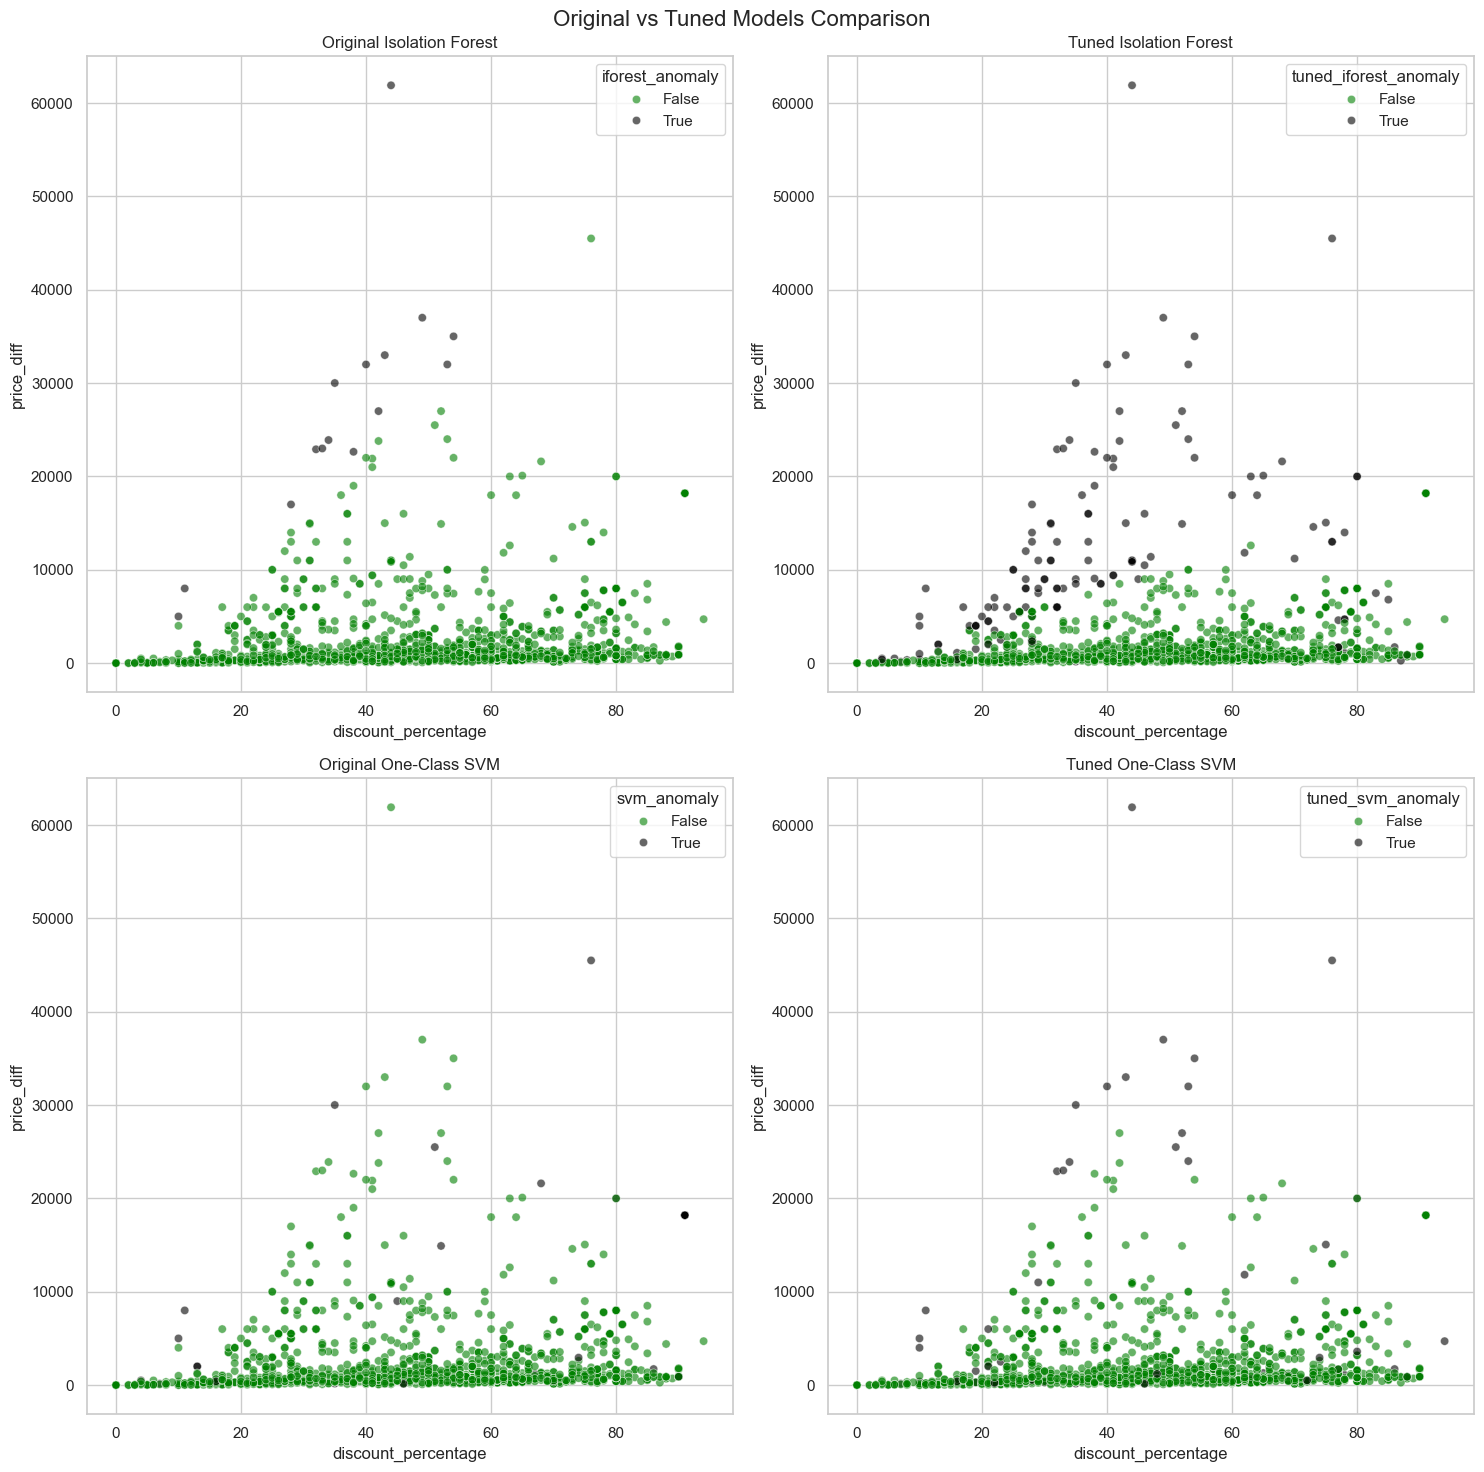


Model Agreement (Original vs Tuned):
Isolation Forest: 90.99% agreement
One-Class SVM: 95.09% agreement


In [27]:

fig, axes = plt.subplots(2, 2, figsize=(15, 15))
fig.suptitle('Original vs Tuned Models Comparison', fontsize=16)

sns.scatterplot(
    data=df,
    x='discount_percentage',
    y='price_diff',
    hue='iforest_anomaly',
    palette={True: 'black', False: 'green'},
    alpha=0.6,
    ax=axes[0,0]
)
axes[0,0].set_title('Original Isolation Forest')


sns.scatterplot(
    data=df,
    x='discount_percentage',
    y='price_diff',
    hue='tuned_iforest_anomaly',
    palette={True: 'black', False: 'green'},
    alpha=0.6,
    ax=axes[0,1]
)
axes[0,1].set_title('Tuned Isolation Forest')


sns.scatterplot(
    data=df,
    x='discount_percentage',
    y='price_diff',
    hue='svm_anomaly',
    palette={True: 'black', False: 'green'},
    alpha=0.6,
    ax=axes[1,0]
)
axes[1,0].set_title('Original One-Class SVM')


sns.scatterplot(
    data=df,
    x='discount_percentage',
    y='price_diff',
    hue='tuned_svm_anomaly',
    palette={True: 'black', False: 'green'},
    alpha=0.6,
    ax=axes[1,1]
)
axes[1,1].set_title('Tuned One-Class SVM')

plt.tight_layout()
plt.show()


iforest_agreement = (df['iforest_anomaly'] == df['tuned_iforest_anomaly']).mean() * 100
svm_agreement = (df['svm_anomaly'] == df['tuned_svm_anomaly']).mean() * 100

print("\nModel Agreement (Original vs Tuned):")
print(f"Isolation Forest: {iforest_agreement:.2f}% agreement")
print(f"One-Class SVM: {svm_agreement:.2f}% agreement")

# Project Summary: Amazon Sales Anomaly Detection

## Overview
This project implements a comprehensive anomaly detection system for Amazon product listings, combining multiple detection methods to identify suspicious patterns in pricing, discounts, and customer reviews.

## Methods Implemented

### 1. Rule-Based Detection
- Invalid pricing (actual price < discounted price)
- Suspiciously high discounts (>90%)
- Suspicious reviews (low rating with high vote count)
- Negative discounts

### 2. Machine Learning Approaches
#### Isolation Forest
- Unsupervised learning algorithm
- Optimized parameters through grid search:
  - n_estimators: [50, 100, 200]
  - contamination: [0.01, 0.05, 0.1]
  - max_features: [0.5, 0.7, 1.0]

#### One-Class SVM
- Support Vector Machine for anomaly detection
- Tuned hyperparameters:
  - nu: [0.01, 0.05, 0.1]
  - gamma: ['scale', 'auto', 0.1, 0.01]
  - kernel: rbf

## Key Features

### Data Processing
- Cleaned currency symbols (₹) and percentage signs
- Standardized numerical values
- Handled missing values
- Feature engineering for price differences

### Advanced Analytics
- Feature importance analysis
- Category-wise anomaly distribution
- Price range analysis
- Correlation analysis between features
- Composite anomaly scoring system

### Visualizations
- Scatter plots for anomaly distribution
- Category-wise analysis charts
- Price range distribution plots
- Correlation heatmaps
- Interactive dashboards

## Results
1. **Rule-Based Detection**
   - Identified basic anomalies in pricing and discounts
   - Caught obvious data entry errors

2. **Machine Learning Detection**
   - Isolation Forest found subtle patterns
   - One-Class SVM provided additional perspective
   - Hyperparameter tuning improved accuracy

3. **Combined Approach**
   - Created comprehensive anomaly scores
   - Identified products requiring attention
   - Provided insights across different price ranges and categories

## Business Impact
- **Quality Control**: Automated detection of pricing errors
- **Fraud Prevention**: Identification of suspicious review patterns
- **Business Intelligence**: Insights into pricing and discount strategies
- **Scalability**: System can handle large product catalogs
- **Flexibility**: Multiple detection methods for different scenarios

## Technical Stack
- Python
- pandas & numpy for data manipulation
- scikit-learn for machine learning
- seaborn & matplotlib for visualization
- plotly for interactive visualizations

## Future Improvements
1. Real-time anomaly detection
2. Additional machine learning models
3. Deep learning implementation
4. API integration
5. Automated reporting system

## Conclusion
This project successfully demonstrates a robust approach to anomaly detection in e-commerce data, combining traditional business rules with modern machine learning techniques. The system provides valuable insights for maintaining data quality and identifying potential issues in product listings.

---
*Project completed as part of data science portfolio*
*Author: Muthukrishnan R*
